# JRC Basic

### no preprocessing, with all labels

## Data Fetching and Preparation


In [1]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

FN='jrc_en.csv'
bs = 32

**Get the dataset**





In [ ]:
df = pd.read_csv(FN)

## keep only text and labels
df = df[['text','labels']]
df.head(2)

## Fine-tuning of the language model

In [ ]:

data_lm = (TextList.from_csv(Path('.'), FN, cols='text', max_vocab=60000, min_freq=2)
           #Inputs: all the text files in path
            # .filter_by_folder(include=['.']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')
print('done')

In [ ]:
data_lm = load_data(Path('.'), 'data_lm.pkl', bs=bs)

In [ ]:
data_lm.show_batch()

In [4]:
# download pre-trained (Wikipedia) model and create learner
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, wd=0.1)

In [ ]:
# test wikidata lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 4
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [ ]:
learn_lm.lr_find()

In [ ]:
learn_lm.recorder.plot(skip_end=15)

In [ ]:
learn_lm.fit_one_cycle(1, 7e-2, moms=(0.8,0.7))

In [ ]:
learn_lm.save('fit_head-JRC')

In [ ]:
learn_lm.load('fit_head-JRC');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
epochs = 2 # orig: 10
learn.fit_one_cycle(epochs, slice(4e-4, 2e-2) , moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned-JRC')

In [ ]:

learn.load('fine_tuned-JRC');

In [ ]:
# test lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 5
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


In [ ]:
learn.save_encoder('fine_tuned_enc-JRC')


## Train a classifier

As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

In [5]:
def my_prc(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def my_rec(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

thresh=0.001
acc_0001 = partial(accuracy_thresh, thresh=thresh)
prc_0001 = partial(my_prc, thresh=thresh)
rec_0001 = partial(my_rec, thresh=thresh)
f_0001 = partial(fbeta, thresh=thresh, beta=1)


thresh=0.01
acc_001 = partial(accuracy_thresh, thresh=thresh)
prc_001 = partial(my_prc, thresh=thresh)
rec_001 = partial(my_rec, thresh=thresh)
f_001 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.05
acc_005 = partial(accuracy_thresh, thresh=thresh)
prc_005 = partial(my_prc, thresh=thresh)
rec_005 = partial(my_rec, thresh=thresh)
f_005 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.1
acc_01 = partial(accuracy_thresh, thresh=thresh)
prc_01 = partial(my_prc, thresh=thresh)
rec_01 = partial(my_rec, thresh=thresh)
f_01 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
prc_02 = partial(my_prc, thresh=thresh)
rec_02 = partial(my_rec, thresh=thresh)
f_02 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.3
acc_03 = partial(accuracy_thresh, thresh=thresh)
prc_03 = partial(my_prc, thresh=thresh)
rec_03 = partial(my_rec, thresh=thresh)
f_03 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.4
acc_04 = partial(accuracy_thresh, thresh=thresh)
prc_04 = partial(my_prc, thresh=thresh)
rec_04 = partial(my_rec, thresh=thresh)
f_04 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.5
acc_05 = partial(accuracy_thresh, thresh=thresh)
prc_05 = partial(my_prc, thresh=thresh)
rec_05 = partial(my_rec, thresh=thresh)
f_05 = partial(fbeta, thresh=thresh, beta=1)


In [ ]:
## make small subsample in order to train faster
df = pd.read_csv(FN)
df = df[['text','labels']]


In [ ]:
data_clas = (TextList.from_csv(Path('.'), FN, vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=';')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [40]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

60000
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'the', ',', 'of', '|', '.', 'and', 'to', 'in', ')', '(', '-']


In [6]:
data_clas = load_data(Path('.'), 'data_clas.pkl', bs=bs)

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.BCEWithLogitsLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
data_clas.show_batch()
#data_clas.label_list


In [ ]:
# do we need all these? test!


# learn = load_learner(Path('.'))
# learn.metrics = [accuracy_thresh, custom_precision, custom_recall,
#                  acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03
#                 ]

# learn.load_encoder('fine_tuned_enc-JRC')
# learn = learn.load('first')



In [7]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
#learn.metrics = [accuracy_thresh, custom_precision, custom_recall, 
#                 acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03 ]
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05 ]
#!mv *pth models
learn.load_encoder('fine_tuned_enc-JRC')


In [8]:
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05
                ]

In [6]:
print(learn.loss_func)
print(learn.loss_func.func)

FlattenedLoss of BCEWithLogitsLoss()
BCEWithLogitsLoss()


In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, slice(2e-2,2e-1), moms=(0.8,0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first')

Why gradual unfreeze? Give example of Image detection.

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
#learn.fit_one_cycle(4, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
learn.fit_one_cycle(3, slice(4e-3/(2.6**4),4e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [9]:
learn.load('third');

In [10]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


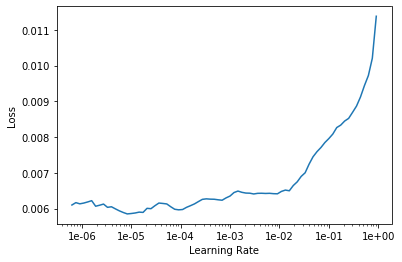

In [11]:
learn.lr_find()
learn.recorder.plot()

In [54]:
#learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..
#learn.fit_one_cycle(15, slice(7e-3/(2.6**4),7e-3), moms=(0.8,0.7)) ## works well
#learn.fit_one_cycle(2, slice(3e-4/(2.6**4),3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.006193,0.006104,0.998603,0.981543,0.734680,0.251630,0.164111,0.996046,0.740019,0.247865,0.327381,0.997652,0.746241,0.243280,0.364364,0.998327,0.761733,0.236199,0.371201,0.998495,0.773662,0.229368,0.350247,0.998567,0.790081,0.222188,0.328588,0.998603,0.805424,0.214894,0.305093,23:11


In [49]:
learn.save('forth')

In [ ]:
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..


In [57]:
learn.save('fortha')

In [ ]:
learn.load('fortha')

In [10]:
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7)) ## too much??? but in the end it comes in nicely ..


epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.006016,0.005862,0.998688,0.873373,0.754125,0.254597,0.039284,0.981335,0.756819,0.253999,0.161406,0.996230,0.765292,0.250677,0.324218,0.997828,0.774250,0.246740,0.366476,0.998474,0.785341,0.239813,0.374757,0.998618,0.797458,0.232076,0.354561,0.998672,0.809669,0.224344,0.333502,0.998688,0.820222,0.216548,0.310292,19:37
1,0.005970,0.005857,0.998690,0.877687,0.753616,0.256659,0.038659,0.982234,0.756105,0.256169,0.162286,0.996352,0.759778,0.253289,0.324381,0.997875,0.764772,0.249841,0.365179,0.998477,0.777247,0.241688,0.368271,0.998618,0.792618,0.233420,0.349038,0.998675,0.806473,0.226584,0.331053,0.998690,0.819048,0.219121,0.309041,18:54
2,0.006107,0.005802,0.998696,0.883763,0.758337,0.256697,0.042894,0.982820,0.759978,0.255951,0.168556,0.996384,0.766007,0.252498,0.328144,0.997870,0.774071,0.249291,0.369582,0.998469,0.785603,0.241977,0.373700,0.998616,0.797286,0.235168,0.356735,0.998677,0.811401,0.227965,0.338198,0.998696,0.821553,0.221186,0.315131,19:19
3,0.006143,0.005790,0.998690,0.887826,0.732482,0.271394,0.049408,0.982552,0.733757,0.270897,0.172001,0.996185,0.739040,0.267851,0.326162,0.997757,0.746527,0.264380,0.365738,0.998412,0.764806,0.256756,0.375572,0.998594,0.778205,0.249867,0.364179,0.998664,0.788560,0.241728,0.347297,0.998690,0.797584,0.234555,0.326074,18:03
4,0.006124,0.005748,0.998701,0.888951,0.756370,0.260244,0.048381,0.983486,0.757433,0.259751,0.178559,0.996487,0.762648,0.257356,0.337563,0.997908,0.767434,0.252433,0.377230,0.998482,0.779739,0.245245,0.378783,0.998635,0.793678,0.239104,0.362313,0.998689,0.804599,0.232910,0.342112,0.998701,0.815013,0.225848,0.319422,19:47
5,0.006115,0.005721,0.998705,0.893508,0.771540,0.256802,0.049595,0.984107,0.773416,0.256190,0.181277,0.996553,0.778181,0.253579,0.342764,0.997935,0.783987,0.250124,0.381821,0.998510,0.794116,0.243603,0.384149,0.998642,0.806084,0.236852,0.363425,0.998697,0.817858,0.230276,0.345626,0.998705,0.828586,0.222957,0.319227,19:33
6,0.006077,0.005689,0.998707,0.895723,0.757913,0.267265,0.048877,0.984246,0.759865,0.266852,0.179731,0.996514,0.766769,0.263832,0.339718,0.997921,0.773278,0.260295,0.382343,0.998491,0.787381,0.252835,0.385238,0.998638,0.800755,0.246184,0.369691,0.998685,0.811248,0.238947,0.347746,0.998707,0.818545,0.231234,0.326432,19:17
7,0.005781,0.005673,0.998705,0.896005,0.745966,0.273955,0.053382,0.984049,0.746658,0.273149,0.185727,0.996484,0.752250,0.268930,0.345826,0.997896,0.757699,0.265109,0.384276,0.998475,0.772599,0.256948,0.386695,0.998625,0.783405,0.249836,0.369937,0.998682,0.794231,0.243342,0.349891,0.998705,0.806452,0.236208,0.329284,19:01
8,0.006001,0.005643,0.998711,0.893767,0.750198,0.274732,0.053320,0.983416,0.751570,0.274371,0.182102,0.996357,0.756587,0.271629,0.342287,0.997866,0.762718,0.267788,0.385100,0.998467,0.773116,0.260609,0.388756,0.998631,0.782361,0.252919,0.375726,0.998691,0.793785,0.246621,0.356156,0.998711,0.803046,0.239271,0.333797,19:11
9,0.005930,0.005647,0.998711,0.898207,0.751348,0.276659,0.053381,0.983951,0.752344,0.275654,0.184015,0.996422,0.755134,0.271800,0.342489,0.997862,0.761585,0.268300,0.384388,0.998475,0.777199,0.261665,0.391849,0.998635,0.787518,0.254144,0.379258,0.998690,0.799273,0.247276,0.357239,0.998711,0.810593,0.240960,0.335504,18:29


In [11]:
learn.save('five')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


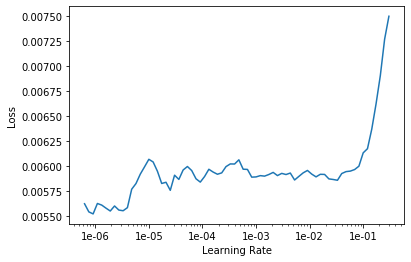

In [41]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
print(learn.predict("Let's make some bread in the oven"))
print(learn.predict("Who likes avocados"))


## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [10]:

learn.load('five')

# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()


In [11]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report




In [18]:
thresh = 0.21

print("F1 (micro)", f1_score(y_true, y_pred>thresh, average='micro'))
print("P (micro)", precision_score(y_true, y_pred>thresh, average='micro'))
print("R (micro)", recall_score(y_true, y_pred>thresh, average='micro'))

print("\nF1 (macro)", f1_score(y_true, y_pred>thresh, average='macro'))
print("P (macro)", precision_score(y_true, y_pred>thresh, average='macro'))
print("R (macro) ", recall_score(y_true, y_pred>thresh, average='macro'))


F1 (micro) 0.44765388496468217
P (micro) 0.5467570482206131
R (micro) 0.3789642285104111

F1 (macro) 0.06942618156259456
P (macro) 0.08184603896190104
R (macro)  0.07270131185555317


In [15]:
f1_score(y_true, y_pred>thresh, average='macro')

0.06942618156259456

In [13]:
y_true_n = y_true.numpy()
scores = y_pred.numpy()
scores.shape, y_true_n.shape

((3503, 3398), (3503, 3398))

In [14]:
metrics = classification_report(y_true_n, scores>thresh, target_names=data_clas.valid_ds.classes)
print(metrics)

              precision    recall  f1-score   support

          10       0.00      0.00      0.00         1
        1000       0.00      0.00      0.00         5
        1005       0.44      0.19      0.27        42
        1008       0.00      0.00      0.00         1
        1010       0.00      0.00      0.00         0
        1011       0.00      0.00      0.00         0
        1012       0.00      0.00      0.00         0
        1015       0.00      0.00      0.00         6
        1018       0.50      0.55      0.52        11
        1019       0.89      0.35      0.50        23
        1021       0.50      0.06      0.11        17
        1025       0.00      0.00      0.00         5
        1026       0.25      1.00      0.40         1
        1030       0.00      0.00      0.00         0
        1031       0.83      0.50      0.62        10
        1034       0.00      0.00      0.00         2
        1035       0.00      0.00      0.00         8
        1036       0.00    

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [20]:
learn.layer_groups


[Sequential(
   (0): Embedding(60000, 400, padding_idx=1)
   (1): EmbeddingDropout(
     (emb): Embedding(60000, 400, padding_idx=1)
   )
 ), Sequential(
   (0): WeightDropout(
     (module): LSTM(400, 1152, batch_first=True)
   )
   (1): RNNDropout()
 ), Sequential(
   (0): WeightDropout(
     (module): LSTM(1152, 1152, batch_first=True)
   )
   (1): RNNDropout()
 ), Sequential(
   (0): WeightDropout(
     (module): LSTM(1152, 400, batch_first=True)
   )
   (1): RNNDropout()
 ), Sequential(
   (0): PoolingLinearClassifier(
     (layers): Sequential(
       (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (1): Dropout(p=0.2)
       (2): Linear(in_features=1200, out_features=50, bias=True)
       (3): ReLU(inplace)
       (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (5): Dropout(p=0.1)
       (6): Linear(in_features=50, out_features=3398, bias=True)
     )
   )
 )]